In [23]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

In [25]:
base = pd.read_csv('data/petr4_treinamento.csv')
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1240,2017-12-25,15.750000,15.750000,15.750000,15.750000,15.718563,0.0
1241,2017-12-26,15.750000,15.990000,15.690000,15.970000,15.938125,22173100.0
1242,2017-12-27,15.990000,16.139999,15.980000,16.049999,16.017963,23552200.0
1243,2017-12-28,16.100000,16.129999,16.000000,16.100000,16.067865,19011500.0


In [26]:
base.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [27]:
base = base.dropna()

In [28]:
base.shape

(1242, 7)

In [29]:
train_base = base.iloc[:, 1:2].values

In [30]:
train_base

array([[19.99    ],
       [19.809999],
       [20.33    ],
       ...,
       [15.99    ],
       [16.1     ],
       [16.1     ]])

In [31]:
normalizer = MinMaxScaler(feature_range=(0, 1))
train_base_normalized = normalizer.fit_transform(train_base)
train_base_normalized

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [32]:
X = [] # previsores
y = [] # preço real

for i in range(90, 1242): # 90 preços anteriores
    X.append(train_base_normalized[i-90:i, 0])
    y.append(train_base_normalized[i, 0])
X, y = np.array(X), np.array(y)

In [34]:
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1, activation='linear'))

regressor.summary()

c:\Users\wilso\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 90, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 90, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,451 (435.36 KB)

 Trainable params: 111,451 (435.36 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
regressor.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [36]:
regressor.fit(X, y, epochs=100, batch_size=32)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 223ms/step - loss: 0.0589 - mean_absolute_error: 0.1827
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - loss: 0.0186 - mean_absolute_error: 0.1064
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 0.0121 - mean_absolute_error: 0.0868
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.0115 - mean_absolute_error: 0.0813
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - loss: 0.0091 - mean_absolute_error: 0.0744
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.0120 - mean_absolute_error: 0.0828
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - loss: 0.0095 - mean_absolute_error: 0.0758
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - loss: 0.0077 - mean_absolute_error: 0.0678
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - loss: 0.0071 - mean_absolute_error: 0.0643
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - loss: 0.0079 - mean_absolute_error: 0.0684
Epoch 11/100
3

In [37]:
test_base = pd.read_csv('data/petr4_teste.csv')
test_base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000
5,2018-01-09,17.030001,17.160000,16.959999,17.030001,16.996010,35070900
6,2018-01-10,16.920000,17.049999,16.770000,16.799999,16.766466,28547700
7,2018-01-11,16.879999,17.299999,16.840000,17.250000,17.215569,37921500
8,2018-01-12,17.040001,17.410000,17.020000,17.299999,17.265469,45912100
9,2018-01-15,17.320000,17.440001,17.150000,17.350000,17.315371,28945400


In [38]:
y_test = test_base.iloc[:, 1:2].values

In [39]:
complete_base = pd.concat((base['Open'], test_base['Open']), axis=0)

In [40]:
inputs = complete_base[len(complete_base) - len(test_base) - 90:].values

In [41]:
inputs = inputs.reshape(-1, 1)

In [42]:
inputs = normalizer.transform(inputs)

In [44]:
X_test = []
for i in range(90, 112):
    X_test.append(inputs[i-90:i, 0])

In [45]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [46]:
predictions = regressor.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [47]:
predictions = normalizer.inverse_transform(predictions)

In [48]:
predictions.mean()

17.287746

In [49]:
y_test.mean()

17.87454563636364

In [50]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions)

0.5868011576177424

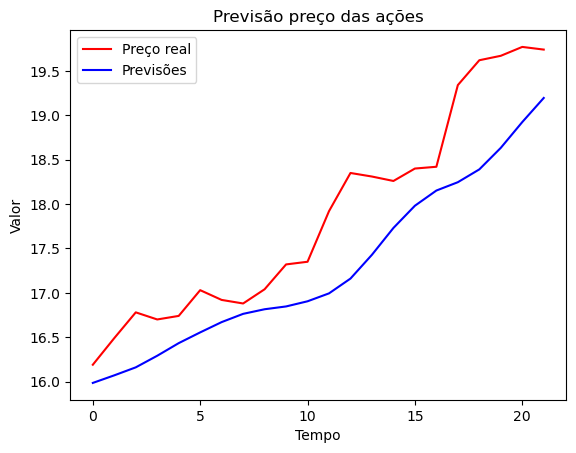

In [51]:
plt.plot(y_test, color='red', label='Preço real')
plt.plot(predictions, color='blue', label='Previsões')
plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()